**Objective**: Learn how to solve a Binary classification problem using neural network in PyTorch.

**Context**: We will study the binary classification problem in the context of a  superstore's initiative. By analyzing customer data, our objective is to build a model that predicts the likelihood of customers opting for the membership offer, aiding the store in efficiently targeting its campaign.

Typically, in such scenarios, there's an imbalance in customer responses, with most customers not opting in for offers. This leads to a skewed dataset where the majority class represents non-responders. This imbalance can effect model performance as model will have tendency to predict majority class. We will study two models :

>Model 1: Train model without accounting for imbalance

>Model 2: Train model accounting for imbalance

**Plan**:
1. Set Environment: Load and understand the libraries needed.
2. Load Data: Load superstore data for this lab and explore it.
3. Split Data: Learn how to split data into training, validation and testing
4. Create Datasets
5. Functions to train & evaluate Models 1, and 2.
6. Train & Evaluate Model 1 (without accounting for Imbalance)
> 6.1. Define Hyperparameters <br>
> 6.2. Define Training Configurations <br>
> 6.3. Model Training & Evaluation <br>
7. Train & Evaluate Model 2 (accounting for Imbalance)
> 7.1. Define Hyperparameters <br>
> 7.2. Define Training Configurations <br>
> 7.3. Model Training & Evaluation <br>
8. Model Selection
9. Model Testing
10. Inference (Predictions) <br>

# <Font color = 'indianred'>**1. Set Environment**

In [2]:
import torch.nn as nn

In [3]:
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix

# Data handling and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random

# file manipulation
from google.colab import drive
from pathlib import Path

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [4]:
if 'google.colab' in str(get_ipython()):
  drive.mount('/content/drive')
  base_folder = Path('/content/drive/MyDrive/data')
else:
  base_folder = Path('/home/harpreet/Insync/google_drive_shaannorr/data')

Mounted at /content/drive


In [5]:
data_folder = base_folder/'datasets'
model_folder = base_folder/'models/nlp_spring_2024/superstore'
model_folder.mkdir(exist_ok=True, parents = True)
data_folder.mkdir(exist_ok=True, parents = True)

# <Font color = 'indianred'>**2. Load Data**

We will use the superstore campaign dataset from the following Kaggle competition: https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset.

**Variable description**

- ` Response (target)` - 1 if customer accepted the offer in the last campaign, 0 otherwise
- `ID` - Unique ID of each customer
- `Year_Birth` - Age of the customer
- `Complain` - 1 if the customer complained in the last 2 years
- `Dt_Customer` - date of customer's enrollment with the company
- `Education` - customer's level of education
- `Marital` - customer's marital status
- `Kidhome` - number of small children in customer's household
- `Teenhome` - number of teenagers in customer's household
- `Income` - customer's yearly household income
- `MntFishProducts` - the amount spent on fish products in the last 2 years
- `MntMeatProducts` - the amount spent on meat products in the last 2 years
- `MntFruits` - the amount spent on fruits products in the last 2 years
- `MntSweetProducts` - amount spent on sweet products in the last 2 years
- `MntWines` - the amount spent on wine products in the last 2 years
- `MntGoldProds` - the amount spent on gold products in the last 2 years
- `NumDealsPurchases` - number of purchases made with discount
- `NumCatalogPurchases` - number of purchases made using catalog (buying goods to be shipped through the mail)
- `NumStorePurchases` - number of purchases made directly in stores
- `NumWebPurchases` - number of purchases made through the company's website
- `NumWebVisitsMonth` - number of visits to company's website in the last month
- `Recency` - number of days since the last purchase

We have removed `Id`, `Dt_Customer`, `Education` and `Marital` from the original dataset. Further, we have removed the rows with missing values. Finally we performed standard scaling of all the variables. The cleaned dataset is provided to you in a CSV file.

**Target variable**\
Target variable in classification is one of the n possible classes. We fix the order of classes and assign them labels starting from 0. Hence, the first class gets the label 0, second class gets the label 1, ..., and the last class gets the label n-1.



In [6]:
df = pd.read_csv(data_folder/'superstore_data_cleaned.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2216 non-null   float64
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   float64
 3   Teenhome             2216 non-null   float64
 4   Recency              2216 non-null   float64
 5   MntWines             2216 non-null   float64
 6   MntFruits            2216 non-null   float64
 7   MntMeatProducts      2216 non-null   float64
 8   MntFishProducts      2216 non-null   float64
 9   MntSweetProducts     2216 non-null   float64
 10  MntGoldProds         2216 non-null   float64
 11  NumDealsPurchases    2216 non-null   float64
 12  NumWebPurchases      2216 non-null   float64
 13  NumCatalogPurchases  2216 non-null   float64
 14  NumStorePurchases    2216 non-null   float64
 15  NumWebVisitsMonth    2216 non-null   f

In [8]:
df.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response
0,0.098441,1.294840,-0.823039,-0.928972,-1.693488,-0.344228,1.951592,0.945465,1.340203,3.944475,3.359503,-0.688176,-0.031124,0.454182,0.061232,-1.781187,-0.097812,1
1,-0.652633,0.192461,-0.823039,-0.928972,-1.693488,0.471186,-0.536787,-0.459326,-0.559697,-0.658233,-0.134455,-0.688176,1.063634,0.112428,0.368919,-0.131574,-0.097812,1
2,-0.902990,0.596794,-0.823039,0.909066,-1.693488,-0.507311,-0.385976,-0.481624,-0.413550,-0.609527,-0.269580,-0.688176,-0.396043,-0.229327,-0.246455,-1.368784,-0.097812,0
3,-0.151917,-0.785669,1.039938,0.909066,-1.693488,-0.874989,-0.662463,-0.740284,-0.687574,-0.658233,-0.848689,-0.688176,-1.125881,-0.912837,-1.169518,0.693232,-0.097812,0
4,1.684040,-1.222743,1.039938,-0.928972,-1.693488,-0.886850,-0.260301,-0.637712,-0.486623,-0.658233,-0.192366,-0.168231,-0.396043,-0.571082,-1.169518,0.693232,-0.097812,1


In [9]:
# Drop the target column, Response, from inputs, X; y is the target column
X = df.drop(['Response'], axis=1).values
y = df['Response'].values

In [10]:
X.shape, y.shape

((2216, 17), (2216,))

In [11]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [12]:
X.shape, y.shape

((2216, 17), (2216,))

# <Font color = 'indianred'>**3. Split Data**

In [13]:
# Splitting the data into training and temporary sets (60% - 40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Splitting the temporary set into validation and test sets (50% - 50% of 40%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Print the shapes of the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1329, 17) (1329,)
Validation set shape: (443, 17) (443,)
Test set shape: (444, 17) (444,)


* explain stratify

# <Font color = 'indianred'>**4. Create Dataset**


In [14]:
class CustomDataset(torch.utils.data.Dataset):

  def __init__(self, X, y):

    # Storing feature data (texts)
    self.X = X
    # Storing the target labels
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):

    # Retrieve the text and corresponding label from the dataset using the index
    inputs = self.X[idx]
    labels = self.y[idx]

    inputs = torch.tensor(inputs, dtype=torch.float32)
    # No need to use view here; we'll use nn.crossEntropy loss function and it doesn't require labels to be a 1-d vector
    # further the loss function need labels to be integers
    labels = torch.tensor(labels, dtype=torch.long)  # same as torch.int64

    # Packing them into a tuple before returning
    sample = (inputs, labels)

    return sample

In [15]:
# Create TensorDatasets for each set
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_dataset, val_dataset, test_dataset

(<__main__.CustomDataset at 0x79ad596fb910>,
 <__main__.CustomDataset at 0x79ad596fb2b0>)

# <Font color = 'indianred'>**5. Functions to train & evaluate Models**

The model training function are similar to numeric prediction notebook. The only change is that we now also track accuracy at every epoch in training and evaluation. This helps us to evaluate model performance during training using not only loss function but also accuracy. Tracking accuracy in addition to loss during model training offers a comprehensive assessment of performance.

## <Font color = 'indianred'>*`step()` function*

In [16]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to calculate loss.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    model = model.to(device)
    inputs = inputs.to(device)

    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Calculate the number of correctly classified samples
    predicted = torch.argmax(outputs.data, 1)
    correct = (predicted == targets).sum().item()

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if loss_function:
      return loss, outputs, correct
    else:
      return None, outputs, correct



* explain step

## <Font color = 'indianred'>*`train_epoch()` function*

In [17]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to calculate loss.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    running_train_correct = 0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, _, correct = step(inputs, targets, model, device, loss_function, optimizer)

        # Update running loss and correct predictions counter
        running_train_loss += loss.item()
        running_train_correct += correct

    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader)
    train_acc = running_train_correct / len(train_loader.dataset)

    return train_loss, train_acc


## <Font color = 'indianred'>*`val_epoch()` function*

In [18]:
def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to calculate loss.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    running_val_correct = 0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Perform a forward pass to get loss and number of correct predictions
            loss, _, correct = step(inputs, targets, model, device, loss_function, optimizer=None)

            # Update running loss and correct predictions counter
            running_val_loss += loss.item()
            running_val_correct += correct

    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    val_acc = running_val_correct / len(valid_loader.dataset)

    return val_loss, val_acc


## <Font color = 'indianred'>*`train()` function*

In [19]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to to calculate loss.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_acc_history (list): History of training accuracy for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_acc_history (list): History of validation accuracy for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_acc = train_epoch(train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_acc = val_epoch(valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_acc*100:.2f}%")
        print()

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history


# <Font color = 'indianred'>**6. Train & Evaluate Model 1 (without accounting for imbalance)**

## <Font color = 'indianred'>*6.1 Hyperparameters*

In [20]:
# Hyperparameters
batch_size = 64
learning_rate = 0.1
number_inputs = 17
number_outputs = 2
number_hidden_1 = 100
number_hidden_2 = 100
epochs = 10

## <Font color = 'indianred'>*6.2 Training Configurations*

In [21]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the MSE loss function
loss_function = nn.CrossEntropyLoss()

# model
hidden_1 = nn.Linear(in_features=number_inputs, out_features=number_hidden_1, bias = True)
hidden_2 = nn.Linear(in_features=number_hidden_1, out_features=number_hidden_2, bias = True)
output_layer = nn.Linear(in_features=number_hidden_1, out_features=number_outputs, bias = True)
model_1 = nn.Sequential(hidden_1, nn.ReLU(), hidden_2, nn.ReLU(), output_layer)


# Define the optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=learning_rate)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## <Font color = 'indianred'>*6.3 Model Training & Evaluation*

In [22]:
# Call the train function to train & evaluate the model
train_losses, train_acc, valid_losses, valid_acc  = train(
    train_loader, val_loader, model_1, optimizer, loss_function, epochs, device)

Epoch 1/10
Train Loss: 0.4743 | Train Accuracy: 84.50%
Valid Loss: 0.4197 | Valid Accuracy: 85.10%

Epoch 2/10
Train Loss: 0.4006 | Train Accuracy: 84.95%
Valid Loss: 0.3911 | Valid Accuracy: 85.10%

Epoch 3/10
Train Loss: 0.3812 | Train Accuracy: 85.03%
Valid Loss: 0.3698 | Valid Accuracy: 85.10%

Epoch 4/10
Train Loss: 0.3640 | Train Accuracy: 85.10%
Valid Loss: 0.3519 | Valid Accuracy: 85.33%

Epoch 5/10
Train Loss: 0.3517 | Train Accuracy: 85.85%
Valid Loss: 0.3382 | Valid Accuracy: 85.78%

Epoch 6/10
Train Loss: 0.3407 | Train Accuracy: 86.31%
Valid Loss: 0.3310 | Valid Accuracy: 85.78%

Epoch 7/10
Train Loss: 0.3333 | Train Accuracy: 86.46%
Valid Loss: 0.3230 | Valid Accuracy: 85.33%

Epoch 8/10
Train Loss: 0.3279 | Train Accuracy: 86.91%
Valid Loss: 0.3212 | Valid Accuracy: 86.23%

Epoch 9/10
Train Loss: 0.3196 | Train Accuracy: 86.76%
Valid Loss: 0.3198 | Valid Accuracy: 85.78%

Epoch 10/10
Train Loss: 0.3183 | Train Accuracy: 86.76%
Valid Loss: 0.3167 | Valid Accuracy: 86.23%


**Plot losses**

In [23]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()


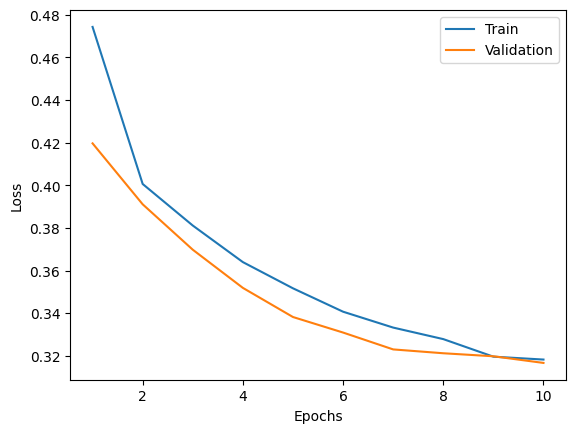

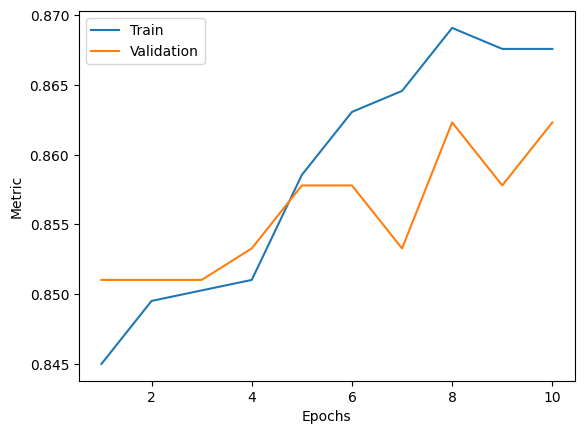

In [24]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

**Evaluate model on validation dataset**\
Examining model performance on one metric such as accuracy does not give complete picture in case of classification. In case of imbalanced data, accuracy may be high even when model predicts positive events poorly. Typically the business need of  predicting positive events correctly is pretty high. Think of an expensive purchase, where a small percentage of potential customers may actually convert. Your business would not want to be wrong and miss such prospects who would have made a purchase. To fix this problem, we can make the mistake of predicting positive event incorrectly more expensive than the mistake of predicting negative event incorrectly. But before we make such an adjustment to loss function, we need to ensure that such a problem indeed exists.

Hence, in the case of classification we would evaluate confusion matrix on validation dataset and decide whether to make a change to loss function. Note, we do not make a change to our model or to loss function based on the test dataset. We did not have to worry about this in numeric prediction dataset, hence, we didn't check for it in the numeric prediction notebook.  

Further, we will use the same function for test dataset and want to get the accuracy for it. Hence, we will extend the function `get_pred` from numeric_prediction notebook to also calculate accuracy.

In [25]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)
    running_correct = 0
    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            _, outputs, correct = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            _, predicted = torch.max(outputs.data, 1)

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets.to(device)))
            running_correct += correct

    # Calculate accuracy by comparing the predicted and actual labels
    accuracy = running_correct / len(data_loader.dataset)

    # Return tuple containing predictions and accuracy
    return predictions, y, accuracy

In [26]:
predictions_valid, labels_valid, acc_valid = get_acc_pred(val_loader, model_1, device)

In [27]:
acc_valid

0.8623024830699775

In [28]:
def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots a confusion matrix.

    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(valid_labels, valid_preds, normalize='true')

    # Plot the confusion matrix using Seaborn
    # 'ax' represents the axes of the plot. Seaborn's heatmap is used for visualizing the confusion matrix
    # 'annot=True' displays the values in the cells, and 'fmt' specifies the string formatting for these values
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)

    # Rotating the tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Adding labels and title to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()


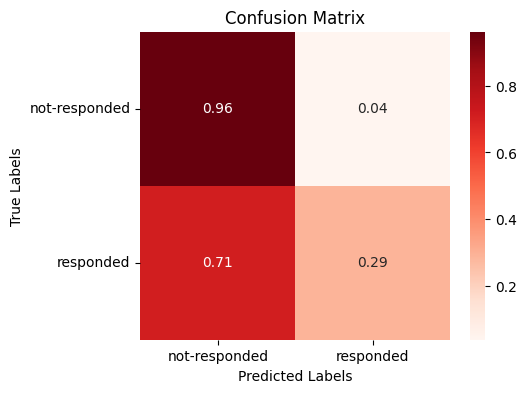

In [29]:
plot_confusion_matrix( labels_valid.cpu().numpy(), predictions_valid.cpu().numpy(), ['not-responded', 'responded'])

**Model checkpointing**



In [30]:
# file name for model to save
file_name_1 = model_folder/'two_layer.pt'

In [31]:
torch.save(model_1.state_dict(), file_name_1)

# <Font color = 'indianred'>**7. Train & Evaluate Model 2 (accounting for imbalance)**

**Problem**: We can see from the above model that it predicts positive class poorly even when the model accuracy is high due to data imbalance.

**Solution**: To address this imbalance, we can modify the loss function. Standard loss functions typically treat all observations equally, but we can adjust this by assigning higher weights to the minority class observations. This approach, known as cost-sensitive learning, encourages the model to reduce errors for the minority class. In PyTorch's nn.CrossEntropy function, this can be implemented by adjusting the 'weight' parameter to favor the minority class.

Next, we will calculate the number of observations in each class and use their inverse as weights in the nn.CrossEntropy loss function, to more effectively balance the influence of each class on the model's learning process. The class with lesser weights will be given more weightsage in loss function.

In [32]:
# Get unique values and their counts
unique, counts = np.unique(y_train, return_counts=True)

# Create a dictionary for value counts
value_counts = dict(zip(unique, counts))

print(value_counts)

{0: 1129, 1: 200}


In [33]:
# Class counts: Low, Medium, High
class_counts = [1144, 200]

# Total number of samples
total = sum(class_counts)

# Calculate weights for each class
weights = torch.tensor([total / c for c in class_counts], dtype=torch.float32)
weights = weights.to('cuda')
weights


tensor([1.1748, 6.7200], device='cuda:0')

## <Font color = 'indianred'>*7.1 Hyperparameters*

In [34]:
# Hyperparameters
batch_size = 64
learning_rate = 0.1
number_inputs = 17
number_outputs = 2
number_hidden_1 = 100
number_hidden_2 = 100
epochs = 10

## <Font color = 'indianred'>*7.2 Training Configurations*

In [35]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the MSE loss function

loss_function = nn.CrossEntropyLoss(weight = weights)

# model
hidden_1 = nn.Linear(in_features=number_inputs, out_features=number_hidden_1, bias = True)
hidden_2 = nn.Linear(in_features=number_hidden_1, out_features=number_hidden_2, bias = True)
output_layer = nn.Linear(in_features=number_hidden_1, out_features=number_outputs, bias = True)
model_2 = nn.Sequential(hidden_1, nn.ReLU(), hidden_2, nn.ReLU(), output_layer)


# Define the optimizer
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## <Font color = 'indianred'>*7.3 Model Training & Evaluation*

In [36]:
# Call the train function to train the model
train_losses, train_acc, valid_losses, valid_acc  = train(
    train_loader, val_loader, model_2, optimizer, loss_function, epochs, device)

Epoch 1/10
Train Loss: 0.6662 | Train Accuracy: 56.36%
Valid Loss: 0.6302 | Valid Accuracy: 64.33%

Epoch 2/10
Train Loss: 0.6184 | Train Accuracy: 67.49%
Valid Loss: 0.5892 | Valid Accuracy: 77.43%

Epoch 3/10
Train Loss: 0.5778 | Train Accuracy: 75.40%
Valid Loss: 0.5406 | Valid Accuracy: 71.11%

Epoch 4/10
Train Loss: 0.5429 | Train Accuracy: 74.27%
Valid Loss: 0.5156 | Valid Accuracy: 76.52%

Epoch 5/10
Train Loss: 0.5241 | Train Accuracy: 75.47%
Valid Loss: 0.4972 | Valid Accuracy: 75.85%

Epoch 6/10
Train Loss: 0.5110 | Train Accuracy: 75.77%
Valid Loss: 0.4990 | Valid Accuracy: 71.33%

Epoch 7/10
Train Loss: 0.5020 | Train Accuracy: 75.09%
Valid Loss: 0.4879 | Valid Accuracy: 77.43%

Epoch 8/10
Train Loss: 0.4894 | Train Accuracy: 75.85%
Valid Loss: 0.4960 | Valid Accuracy: 70.88%

Epoch 9/10
Train Loss: 0.4850 | Train Accuracy: 76.60%
Valid Loss: 0.4880 | Valid Accuracy: 76.75%

Epoch 10/10
Train Loss: 0.4805 | Train Accuracy: 78.03%
Valid Loss: 0.4883 | Valid Accuracy: 74.49%


**Plot losses**

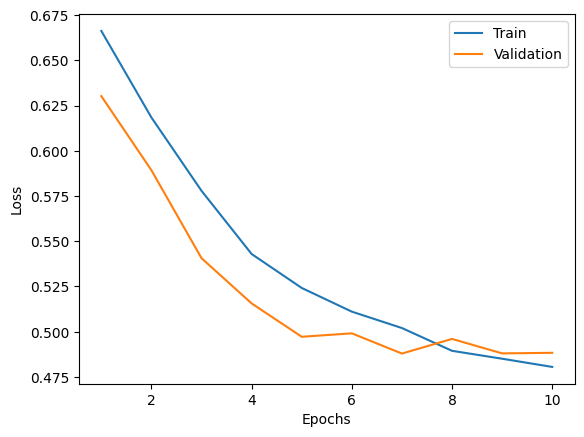

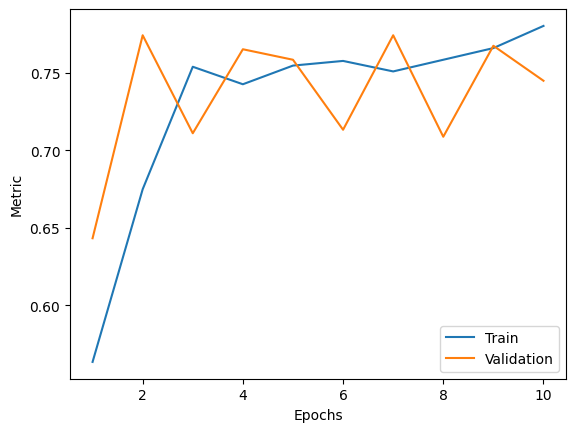

In [37]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

****

In [38]:
predictions_valid, labels_valid, acc_valid = get_acc_pred(val_loader, model_2, device)

In [39]:
acc_valid

0.744920993227991

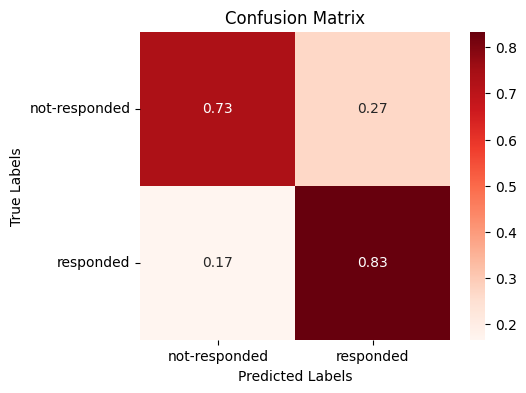

In [40]:
plot_confusion_matrix( labels_valid.cpu().numpy(), predictions_valid.cpu().numpy(), ['not-responded', 'responded'])

**Model checkpointing**

In [41]:
# file name for model to save
file_name_2 = model_folder/'two_layer_cost.pt'

In [42]:
torch.save(model_2.state_dict(), file_name_2 )

# <Font color = 'indianred'>**8. Model Selection**

We can see from the above results that model 2 gave us the more balanced results. The overall validation accuracy of model 1 (0.86) is higer than validation accuracy of model 2 (0.74). However, model 1 predicts positive class poorly. For, imbalanced dataset even a naive model where we always predict negative class can give good overall accuracy. For example if the 90% of observation are from negative class, then always predicting negative class will give us 90% accuracy. Therefore, in such scenarios, we will prefer a model that performs reasonably well on all the classes. Hence, we will choose model 2 as the final model and proceed with it.

# <Font color = 'indianred'>**9. Model Testing**

**Load saved model**

In [43]:
# instantiate model
hidden_1 = nn.Linear(in_features=number_inputs, out_features=number_hidden_1, bias = True)
hidden_2 = nn.Linear(in_features=number_hidden_1, out_features=number_hidden_2, bias = True)
output_layer = nn.Linear(in_features=number_hidden_1, out_features=number_outputs, bias = True)
trained_model_2 = nn.Sequential(hidden_1, nn.ReLU(), hidden_2, nn.ReLU(), output_layer)

# Load the model's state dictionary from the specified checkpoint file
checkpoint_2 = torch.load(file_name_2)

# Load the saved state dictionary into the model
trained_model_2.load_state_dict(checkpoint_2)


<All keys matched successfully>

**Evaluate Model on Test Set**

In [44]:
predictions_test_2, labels_test_2 , test_acc_2 = get_acc_pred(val_loader, trained_model_2, device)

In [45]:
test_acc_2

0.744920993227991

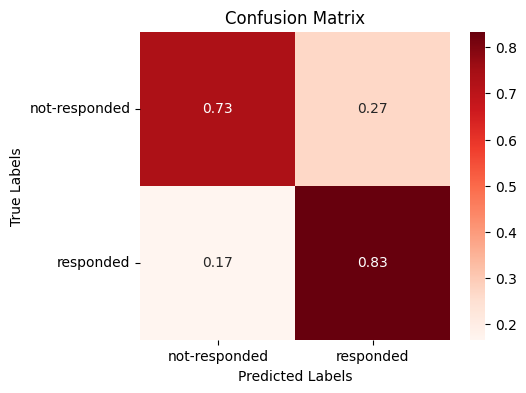

In [46]:
plot_confusion_matrix(labels_test_2.cpu().numpy(), predictions_test_2.cpu().numpy(), ['not-responded', 'responded'])

We can see that performance of Model 2 on test set is comparable to the performance on validation set. Hence, we can conclude that model can generalize to unseen dataset. We will now use the model for inference.

# <Font color = 'indianred'>**10. Inference (Predictions)**

In [47]:
sample_X = torch.tensor(X_train[0:5]).float().to(device)
logits_2 = trained_model_2(sample_X)
logits_2

tensor([[ 0.8547, -0.9826],
        [ 0.5779, -0.5601],
        [ 0.9218, -0.8613],
        [ 1.8239, -1.8883],
        [-1.4090,  1.0810]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [48]:
predictions_2 = torch.argmax(logits_2, 1)
predictions_2

tensor([0, 0, 0, 0, 1], device='cuda:0')